covid 19 data use for 5 alogorithm
Comparing Linear Regression, Random Forest Regression,
 XGBoost, LSTMs, and ARIMA Time Series Forecasting


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.utils import np_utils
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle


In [0]:
df_confirmed = pd.read_csv("/content/time_series_covid19_confirmed_global.csv")
df_recovered = pd.read_csv("/content/time_series_covid19_recovered_global.csv")
df_deaths = pd.read_csv("/content/time_series_covid19_deaths_global.csv")

df_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
df_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
df_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
df = pd.read_csv('/content/covid_19_clean_complete.csv',parse_dates=['Date'])
df.rename(columns={'ObservationDate':'Date', 'Country/Region':'Country'}, inplace=True)

In [0]:
df_confirmed.head()

,Province/State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3


In [0]:
df_recovered.head()

,Province/State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,5,5,5,5,5,5,5,5,5,5,5,10,10,10,10,10,12,12,12,14,15,15,15,15,17,17,21,21,22,22,22,28,28,28,31,31,31,31,31,31,31,31,33,34,34,35,35,35,35,41,42,42,42,42,44,44.0
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,9,9,9,9,12,12,12,13,18,18,22,22,22,22,22,22,22,22,32,32,32,43,43,43,46,76,76,76,101,118,118,118,118,118,144,144,144,150,191,232,235,235.0
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,9,15,15,17,18,18,24,29,34,34,37,37,51,51,53,62,62,62,72,72,78,78,78,78,78,78,78,78,78,96,96,97,105,105,109,114,114,114,124,140,144,144.0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,3,7,7,7,13,15,15,15,15,15,18,18,18,18,18,18,18,18,22,22,22,22,23,24,24,24,26,26,26,35,42,42,49,60,75,87,114,139,139.0


In [0]:
df.head()

,Province/State,Country,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2.0,0.0,0.0
1,NaN,Japan,36.0000,138.0000,2020-01-22,2.0,0.0,0.0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0.0,0.0,0.0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0.0,0.0,0.0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0.0,0.0,0.0


In [0]:
df_data = df.groupby(["Date", "Country", "Province/State"])[['Date', 'Province/State', 'Country', 'Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
df_data.head()

,Date,Country,Province/State,Confirmed,Deaths,Recovered
0,2020-01-22,Australia,Australian Capital Territory,0.0,0.0,0.0
1,2020-01-22,Australia,From Diamond Princess,0.0,0.0,0.0
2,2020-01-22,Australia,New South Wales,0.0,0.0,0.0
3,2020-01-22,Australia,Northern Territory,0.0,0.0,0.0
4,2020-01-22,Australia,Queensland,0.0,0.0,0.0


## Corona cases in Italy 

In [0]:
df.query('Country=="Italy"').groupby("Date")[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

,Date,Confirmed,Deaths,Recovered
0,2020-01-22,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0
2,2020-01-24,0.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0
4,2020-01-26,0.0,0.0,0.0
...,...,...,...,...
57,2020-03-19,41035.0,3405.0,4440.0
58,2020-03-20,47021.0,4032.0,4440.0
59,2020-03-21,53578.0,4825.0,6072.0
60,2020-03-22,59138.0,5476.0,7024.0


In [0]:
df3=df.groupby('Date').sum()
df3.head()

,Lat,Long,Confirmed,Deaths,Recovered
Date,,,,,
2020-01-22,7777.4793,1639.7021,554.0,17.0,28.0
2020-01-23,7777.4793,1639.7021,652.0,18.0,30.0
2020-01-24,7777.4793,1639.7021,939.0,26.0,36.0
2020-01-25,7777.4793,1639.7021,1432.0,42.0,39.0
2020-01-26,7777.4793,1639.7021,2113.0,56.0,52.0


In [0]:
confirmed = df.groupby('Date').sum()['Confirmed'].reset_index()
deaths = df.groupby('Date').sum()['Deaths'].reset_index()
recovered = df.groupby('Date').sum()['Recovered'].reset_index()

In [0]:
confirmed.head()

,Date,Confirmed
0,2020-01-22,554.0
1,2020-01-23,652.0
2,2020-01-24,939.0
3,2020-01-25,1432.0
4,2020-01-26,2113.0


In [0]:
def monthly_cases(data):
    monthly_data = data.copy()
    monthly_data.Date = monthly_data.Date.apply(lambda x: str(x)[:-3])
    monthly_data = monthly_data.groupby('Date')['Confirmed'].sum().reset_index()
    monthly_data.Date = pd.to_datetime(monthly_data.Date)
    return monthly_data


In [0]:
monthly_df = monthly_cases(confirmed)
monthly_df


,Date,Confirmed
0,2020-01-22,554.0
1,2020-01-23,652.0
2,2020-01-24,939.0
3,2020-01-25,1432.0
4,2020-01-26,2113.0
...,...,...
57,2020-03-19,242708.0
58,2020-03-20,272166.0
59,2020-03-21,304524.0
60,2020-03-22,335955.0


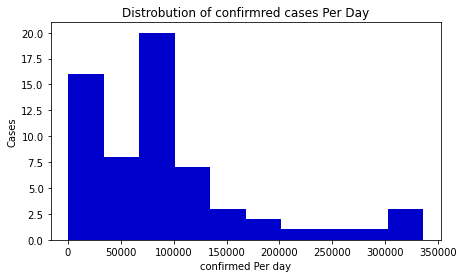

In [0]:
def confirmed_cases_per_day():
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(monthly_df.Confirmed, color='mediumblue')
    
    ax.set(xlabel = "confirmed Per day",
           ylabel = "Cases",
           title = "Distrobution of confirmred cases Per Day")
    
confirmed_cases_per_day()

In [0]:
# Average monthly confirmed cases

# Overall
avg_monthly_cases = monthly_df.Confirmed.mean()
print(f"Overall average monthly confirmed cases: ${avg_monthly_cases}")


Overall average monthly confirmed cases: $89193.08064516129


# Determining Stationarity

In [0]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total cases')
    
    second = data.groupby(data.Date.dt.year)[y_col].mean().reset_index()
    second.Date = pd.to_datetime(second.Date, format='%Y')
    sns.lineplot((second.Date + datetime.timedelta(365/12)), y_col, data=second, ax=ax, color='red', label='Mean cases')   
    
    ax.set(xlabel = "Date",
           ylabel = "confirmed",
           title = title)
    
    sns.despine()

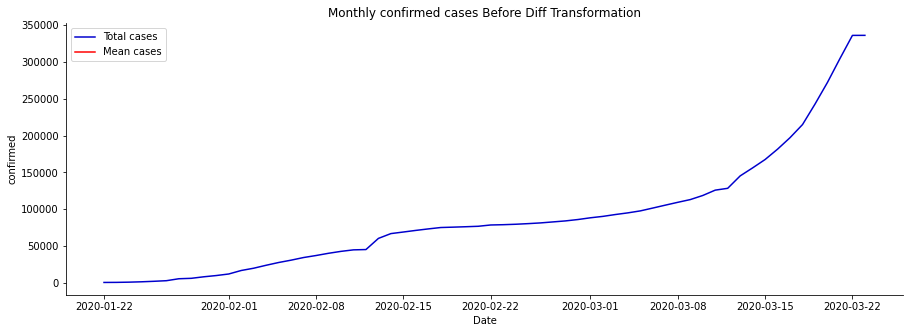

In [0]:
time_plot(monthly_df, 'Date', 'Confirmed','Monthly confirmed cases Before Diff Transformation')

In [0]:
def get_diff(data):
    data['Confirmed_diff'] = data.Confirmed.diff()
    data = data.dropna()
    
    return data

In [0]:
stationary_df = get_diff(monthly_df)

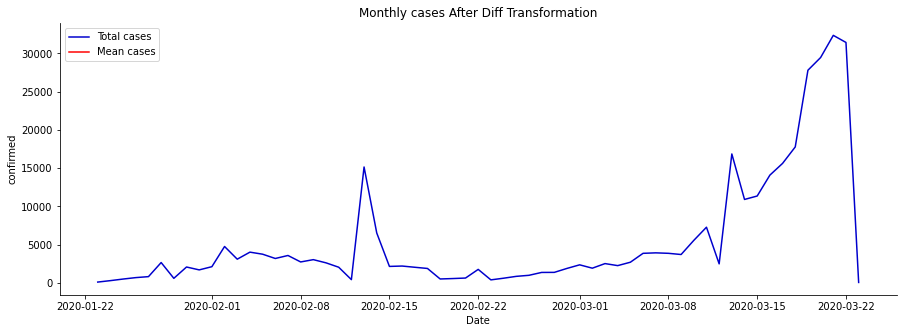

In [0]:
time_plot(stationary_df, 'Date', 'Confirmed_diff', 'Monthly cases After Diff Transformation')

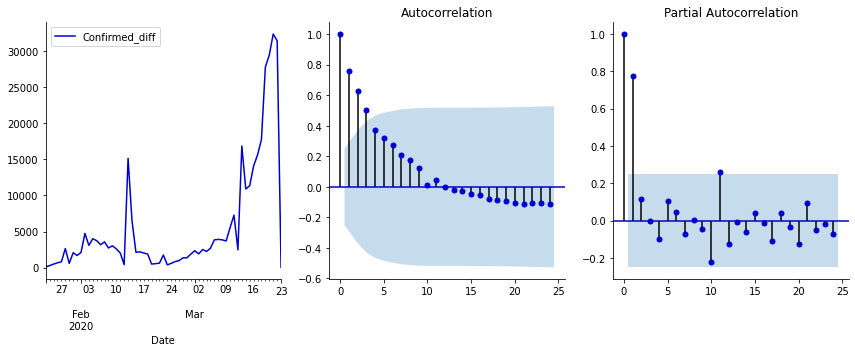

In [0]:
def plots(data, lags=None):
    
    # Convert dataframe to datetime index
    dt_data = data.set_index('Date').drop('Confirmed', axis=1)
    dt_data.dropna(axis=0)
    
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(12, 5), color='mediumblue')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()

plots(stationary_df, lags=24);

# Preparing Dataset Modeling

In [0]:
#create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['Confirmed_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
   # supervised_df.to_csv('../data/model_df.csv', index=False)
    
    return supervised_df

In [0]:
model_df = generate_supervised(stationary_df)
model_df

,Date,Confirmed,Confirmed_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2020-02-04,23881.0,4011.0,3091.0,4749.0,2110.0,1691.0,2068.0,588.0,2651.0,809.0,681.0,493.0,287.0,98.0
1,2020-02-05,27624.0,3743.0,4011.0,3091.0,4749.0,2110.0,1691.0,2068.0,588.0,2651.0,809.0,681.0,493.0,287.0
2,2020-02-06,30806.0,3182.0,3743.0,4011.0,3091.0,4749.0,2110.0,1691.0,2068.0,588.0,2651.0,809.0,681.0,493.0
3,2020-02-07,34380.0,3574.0,3182.0,3743.0,4011.0,3091.0,4749.0,2110.0,1691.0,2068.0,588.0,2651.0,809.0,681.0
4,2020-02-08,37109.0,2729.0,3574.0,3182.0,3743.0,4011.0,3091.0,4749.0,2110.0,1691.0,2068.0,588.0,2651.0,809.0
5,2020-02-09,40139.0,3030.0,2729.0,3574.0,3182.0,3743.0,4011.0,3091.0,4749.0,2110.0,1691.0,2068.0,588.0,2651.0
6,2020-02-10,42751.0,2612.0,3030.0,2729.0,3574.0,3182.0,3743.0,4011.0,3091.0,4749.0,2110.0,1691.0,2068.0,588.0
7,2020-02-11,44790.0,2039.0,2612.0,3030.0,2729.0,3574.0,3182.0,3743.0,4011.0,3091.0,4749.0,2110.0,1691.0,2068.0
8,2020-02-12,45209.0,419.0,2039.0,2612.0,3030.0,2729.0,3574.0,3182.0,3743.0,4011.0,3091.0,4749.0,2110.0,1691.0
9,2020-02-13,60355.0,15146.0,419.0,2039.0,2612.0,3030.0,2729.0,3574.0,3182.0,3743.0,4011.0,3091.0,4749.0,2110.0


# ARIMA Modeling

In [0]:
def generate_arima_data(data):
    dt_data = data.set_index('Date').drop('Confirmed', axis=1)
    dt_data.dropna(axis=0)
    
    #dt_data.to_csv('../data/arima_df.csv')
    
    return dt_data

In [0]:
datetime_df = generate_arima_data(stationary_df)
datetime_df

,Confirmed_diff
Date,
2020-01-23,98.0
2020-01-24,287.0
2020-01-25,493.0
2020-01-26,681.0
2020-01-27,809.0
...,...
2020-03-19,27798.0
2020-03-20,29458.0
2020-03-21,32358.0


# Train Test Split

In [0]:
def tts(data):
    data = data.drop(['Date','Confirmed'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    
    return train, test

train, test = tts(model_df)


In [0]:
train.shape

(37, 13)

In [0]:
test.shape

(12, 13)

In [0]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [0]:
y_train.shape

(37,)

# Modeling Functions

In [0]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [0]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = confirmed
    original_df.Date = original_df.Date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('Date')['Confirmed'].sum().reset_index()
    original_df.Date = pd.to_datetime(original_df.Date)
    #df['Timestamp'] = pd.to_datetime(df['Year'],format='%Y') 
    return original_df

In [0]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted cases
    result_list = []
    cases_dates = list(original_df[-14:].Date)
    act_confirmed = list(original_df[-14:].Confirmed)

    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_confirmed[index])
        result_dict['Date'] = cases_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
        
    return df_result

In [0]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.Confirmed[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.Confirmed[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.Confirmed[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [0]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.Date, original_df.Confirmed, data=original_df, ax=ax,label='Original', color='mediumblue')
    sns.lineplot(results.Date, results.pred_value, data=results, ax=ax,label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Confirmed",
           title = f"{model_name} corona Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
   # plt.savefig(f'../model_output/{model_name}_forecast.png')

In [0]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

# Linear Regression

RMSE: 30750.273678998914
MAE: 27353.0
R2 Score: 0.8109100329701195


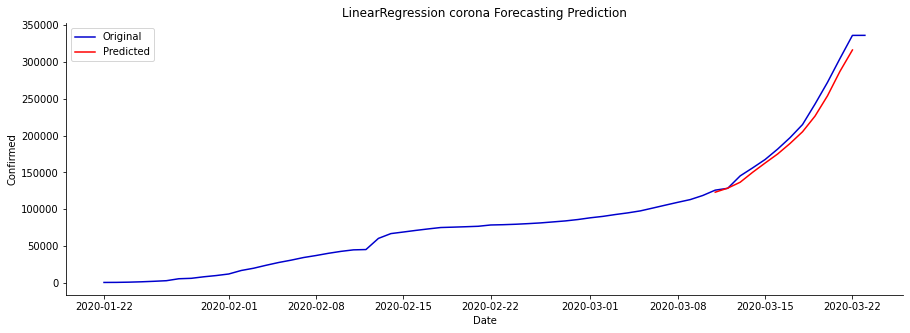

In [0]:
run_model(train, test, LinearRegression(), 'LinearRegression')

# Random Forest Regressor

RMSE: 33605.49337905932
MAE: 29514.916666666668
R2 Score: 0.7741650950600928


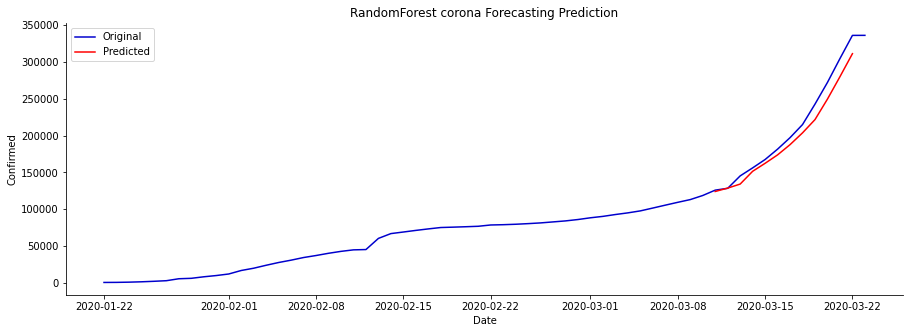

In [0]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20),'RandomForest')

# XGBoost

RMSE: 34463.973145880904
MAE: 30254.666666666668
R2 Score: 0.7624794436680555


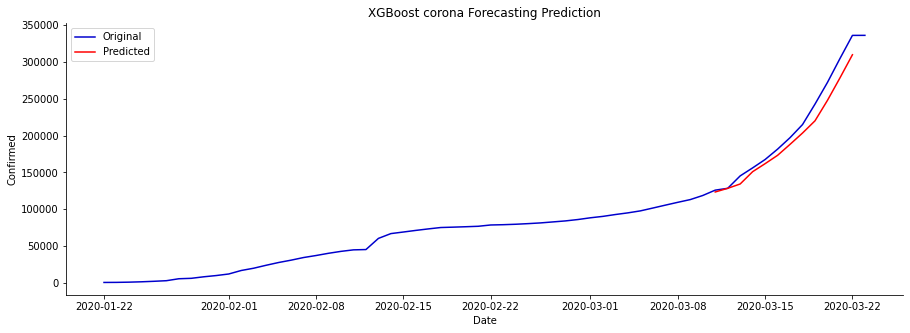

In [0]:
run_model(train, test, XGBRegressor( n_estimators=100, learning_rate=0.2, objective='reg:squarederror'), 'XGBoost')

# LSTM

In [0]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = confirmed
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')

Epoch 1/200
37/37 [==============================] - 0s 7ms/step - loss: 0.2436
Epoch 2/200
37/37 [==============================] - 0s 2ms/step - loss: 0.1701
Epoch 3/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1474
Epoch 4/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1408
Epoch 5/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1380
Epoch 6/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1361
Epoch 7/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1346
Epoch 8/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1334
Epoch 9/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1324
Epoch 10/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1316
Epoch 11/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1309
Epoch 12/200
37/37 [==============================] - 0s 1ms/step - loss: 0.1303
Epoch 13/200
37/37 [=================

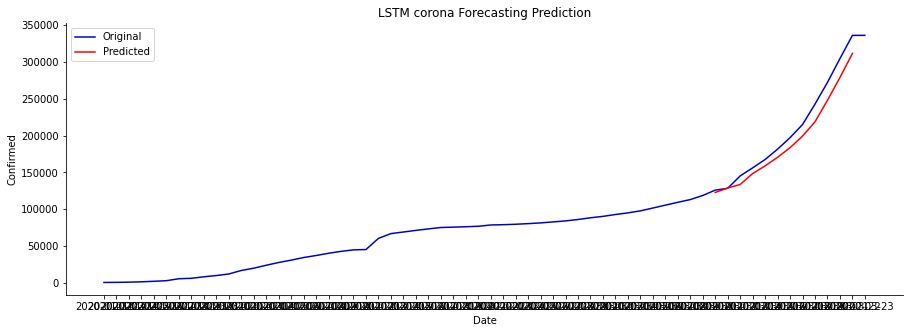

In [0]:
lstm_model(train, test)

In [0]:
pickle.dump(model_scores, open( "model_scores.p", "wb" ) )

# Arima module

# SARIMAX Modeling

In [0]:
ts_data = datetime_df

In [0]:
ts_data.index = pd.to_datetime(ts_data.index)

In [0]:
def get_scores(data):
    
    model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(data.Confirmed_diff[-12:], data.forecast[-12:]))
    mae = mean_absolute_error(data.Confirmed_diff[-12:], data.forecast[-12:])
    r2 = r2_score(data.Confirmed_diff[-12:], data.forecast[-12:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
    pickle.dump(model_scores, open( "arima_model_scores.p", "wb" ))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


RMSE: 13795.856943704908
MAE: 11771.17930550652
R2 Score: -0.7688895077646689


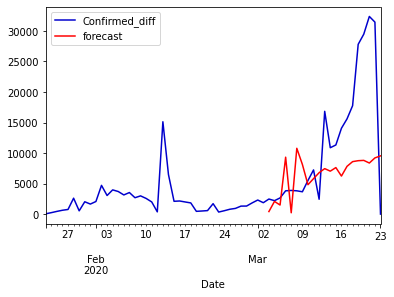

In [0]:
def sarimax_model(data):
    
    # Model
    sar = sm.tsa.statespace.SARIMAX(ts_data.Confirmed_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()

    # Predictions
    start, end, dynamic = 40, 100, 7
    data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start+dynamic:end]
    
    data[['Confirmed_diff', 'forecast']].plot(color=['mediumblue', 'Red'])
    
    get_scores(data)

    return sar, data, pred_df

sar, ts_data, predictions = sarimax_model(ts_data)

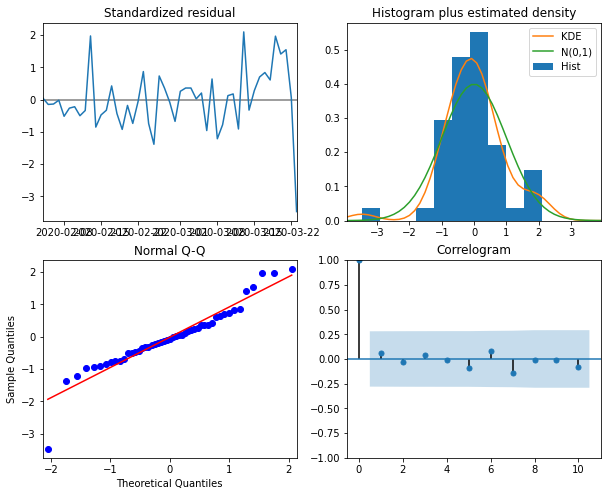

In [0]:
sar.plot_diagnostics(figsize=(10, 8));

# Plot Results


In [0]:
def predict_df(prediction_df):
    
    #load in original dataframe without scaling applied
    original_df = confirmed
    original_df.Date = original_df.Date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('Date')['Confirmed'].sum().reset_index()
    original_df.Date = pd.to_datetime(original_df.Date)
    
    #create dataframe that shows the predicted sales
    result_list = []
    conf_dates = list(original_df[-14:].Date)
    act_conf = list(original_df[-14:].Confirmed)
    
    for index in range(0,len(prediction_df)):
        result_dict = {}
        result_dict['pred_value'] = int(prediction_df[index] + act_conf[index])
        result_dict['Date'] = conf_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result, original_df

In [0]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.Date, original_df.Confirmed, data=original_df, ax=ax, 
                label='Original', color='mediumblue')
    sns.lineplot(results.Date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Confirmed",
           title = f"{model_name} corona Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
     # plt.savefig(f'../model_output/{model_name}_forecast.png')

In [0]:
#prediction_df, original_df = predict_df(predictions)


In [0]:
plot_results(prediction_df, original_df, 'arima')

# Create Results Dataframe

In [0]:
def create_results_df():
    results_dict = pickle.load(open("model_scores.p", "rb"))
    
    results_dict.update(pickle.load(open("arima_model_scores.p", "rb")))
    
    restults_df = pd.DataFrame.from_dict(results_dict, orient='index', 
                                        columns=['RMSE', 'MAE','R2'])
    
    restults_df = restults_df.sort_values(by='RMSE', ascending=False).reset_index()
    
    return restults_df

In [0]:
results = create_results_df()
results

,index,RMSE,MAE,R2
0,LSTM,35623.237125,31662.750000,0.746232
1,XGBoost,34463.973146,30254.666667,0.762479
2,RandomForest,33605.493379,29514.916667,0.774165
3,LinearRegression,30750.273679,27353.000000,0.810910
4,ARIMA,13795.856944,11771.179306,-0.768890


# Plot Results

In [0]:
fig, ax = plt.subplots(figsize=(12, 5))
    sns.lineplot(np.arange(len(results_df)), 'RMSE', data=results_df, ax=ax, 
                 label='RMSE', color='mediumblue')
    sns.lineplot(np.arange(len(results_df)), 'MAE', data=results_df, ax=ax, 
                 label='MAE', color='Cyan')
    
    plt.xticks(np.arange(len(results_df)),rotation=45)
    ax.set_xticklabels(results_df['index'])
    ax.set(xlabel = "Model",
           ylabel = "Scores",
           title = "Model Error Comparison")
    sns.despine()
    
   # plt.savefig(f'../model_output/compare_models.png')

IndentationError: ignored

In [0]:
#plot_results(results)

In [0]:
average_monthly_confirmed_cases= 89193.08064516129
gboost = 34463.973146
percentage_off = round(gboost/average_monthly_confirmed_cases*100, 2)

print(f"With XGBoost, prediction is within {percentage_off}% of the actual.")

With XGBoost, prediction is within 38.64% of the actual.
